In [1]:
%pip install tsmoothie
%pip install catboost

  Using cached tsmoothie-1.0.4-py3-none-any.whl (21 kB)
  Using cached simdkalman-1.0.2-py2.py3-none-any.whl (11 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached catboost-1.1.1-cp310-none-manylinux1_x86_64.whl (76.6 MB)
  Using cached plotly-5.13.1-py2.py3-none-any.whl (15.2 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
from ipyleaflet import Map, Marker
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd
from tsmoothie.utils_func import sim_randomwalk
from tsmoothie.smoother import LowessSmoother, KalmanSmoother
from tsmoothie.bootstrap import BootstrappingWrapper
import xarray as xr

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix
from catboost import CatBoostClassifier, Pool

# Planetary Computer Tools
import pystac
import pystac_client
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc
pc.settings.set_subscription_key('d2de6b1461274bc0b832979219b018a9')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
tqdm.pandas()

In [23]:
#py kernel must be in same location as data directory
crop_presence_data = pd.read_csv("PlanetaryComputerExamples/OpenDataChallenge/Data/Crop_Location_Data_20221201.csv")
crop_presence_data.head()

,Latitude and Longitude,Class of Land
0,"(10.323727047081501, 105.2516346045924)",Rice
1,"(10.322364360592521, 105.27843410554115)",Rice
2,"(10.321455902933202, 105.25254306225168)",Rice
3,"(10.324181275911162, 105.25118037576274)",Rice
4,"(10.324635504740822, 105.27389181724476)",Rice


In [6]:
def create_bbox(lat_long, size_px):
    
    box_size_deg = 0.00007 * size_px 

    min_lon = lat_long[1]-box_size_deg/2
    min_lat = lat_long[0]-box_size_deg/2
    max_lon = lat_long[1]+box_size_deg/2
    max_lat = lat_long[0]+box_size_deg/2

    bbox = (min_lon, min_lat, max_lon, max_lat)
    return bbox

def smooth_data(data, window_size=3):
    data = data.rolling(window_size, center=True).mean()
    return data

def db_scale(x):
    return 10 * np.log10(x)

In [7]:
def get_sentinel_data(latlong, time_slice,assets, bbox_size_px = 5):
    '''
    Returns VV and VH values for a given latitude and longitude 
    Attributes:
    latlong - A tuple with 2 elements - latitude and longitude
    time_slice - Timeframe for which the VV and VH values have to be extracted
    assets - A list of bands to be extracted
    '''
    
    latlong=latlong.replace('(','').replace(')','').replace(' ','').split(',')
    bbox = create_bbox([float(latlong[0]),float(latlong[1])], bbox_size_px)
    time_of_interest = time_slice

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1"
    )
    search = catalog.search(
        collections=["sentinel-1-rtc"], bbox=bbox, datetime=time_of_interest
    )
    items = list(search.get_all_items())
    bands_of_interest = assets
    data = stac_load(items, bands = bands_of_interest, patch_url=pc.sign, bbox=bbox) 
    return data

In [9]:
time_slice = "2020-01-04/2021-01-04"
assets = ['vh','vv']
coordinates=crop_presence_data['Latitude and Longitude']
datasets = []
for i in tqdm(range(0,len(coordinates))):
    data = db_scale(get_sentinel_data(coordinates[i],time_slice,assets, bbox_size_px = 5))
    data.mean(dim=['x','y']).compute()
    data.to_netcdf('./Data/RawData/raw_data_' + str(i) + '.nc')
    datasets.append(data)


100%|██████████| 5/5 [01:39<00:00, 19.95s/it]


Relevant data has been downloaded, now Preprocessing

In [37]:
#get sample data from Data/RawData files
dataArray = []
for i in tqdm(range(0,599)):
    data = xr.open_dataset('PlanetaryComputerExamples/OpenDataChallenge/Data/RawData/raw_data_'+str(i)+'.nc')
    data = data.mean(dim=['x','y']).compute()
    dataArray.append(data)
data = xr.concat(dataArray, dim='place')

100%|██████████| 599/599 [00:08<00:00, 71.34it/s]


In [44]:
data = data.interpolate_na(dim='time', method='linear')

In [45]:

crossCo = (data.vh/data.vv).to_dataset(name='crossCo')
data = data.merge(crossCo)

MergeError: conflicting values for variable 'crossCo' on objects to be combined. You can skip this check by specifying compat='override'.

In [46]:
data

<xarray.Dataset>
Dimensions:      (time: 121, place: 599)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-09T11:11:41.420743 ... 2021-01...
    spatial_ref  int32 32648
Dimensions without coordinates: place
Data variables:
    vh           (place, time) float32 -15.35 -16.22 -16.22 ... -13.73 -11.84
    vv           (place, time) float32 -10.2 -10.82 -10.82 ... -7.063 -7.067
    crossCo      (place, time) float32 1.506 1.499 1.499 ... 1.499 1.943 1.675

In [47]:
#apply time series smoothing
smoother = LowessSmoother(smooth_fraction=0.1, iterations=1)
smooth_data = []	
for i in tqdm(range(0,len(data.place))):
    smoother.smooth(data.isel(place=i).to_array(dim='time'))
    smooth_data.append(xr.DataArray(smoother.smooth_data, dims=['bands', 'time'], coords={'bands':['vv','vh','crossCo'], 'time':data.time}))


smooth_data = xr.concat(smooth_data, dim='place')

 

In [48]:
smooth_data

<xarray.DataArray (place: 599, bands: 3, time: 121)>
array([[[-15.752785 , -15.972566 , -16.180798 , ..., -21.321499 ,
         -21.848656 , -22.329203 ],
        [ -9.898344 , -10.546859 , -11.179807 , ..., -11.338227 ,
         -11.323619 , -11.259722 ],
        [  1.5667416,   1.5173776,   1.4684968, ...,   1.9686794,
           2.021379 ,   2.0762289]],

       [[-16.87955  , -16.77486  , -16.655346 , ..., -23.243227 ,
         -23.846329 , -24.4189   ],
        [ -5.240178 ,  -6.1375356,  -7.0367084, ..., -14.874654 ,
         -15.397693 , -15.908223 ],
        [  3.1772351,   2.9220786,   2.668759 , ...,   1.6290833,
           1.6108236,   1.5906993]],

       [[-17.096704 , -17.066566 , -17.02168  , ..., -21.996199 ,
         -23.252699 , -24.507687 ],
        [ -9.479849 , -10.134911 , -10.745122 , ..., -11.919909 ,
         -12.701747 , -13.498853 ],
        [  2.2466385,   2.0735478,   1.9104155, ...,   1.9228259,
           1.9131795,   1.9017015]],
...
       [[-11.406278 , -11.473569 , -11.537564 , ..., -13.062335 ,
         -13.274047 , -13.496839 ],
        [ -4.502212 ,  -4.5742106,  -4.642202 , ...,  -5.3580375,
          -5.3254724,  -5.287736 ],
        [  2.7854412,   2.7371476,   2.6908734, ...,   2.4432755,
           2.4883819,   2.5387871]],

       [[-12.340786 , -12.323689 , -12.302532 , ..., -11.8796215,
         -12.011587 , -12.156003 ],
        [ -4.5451636,  -4.6148715,  -4.6820273, ...,  -5.365828 ,
          -5.487037 ,  -5.615774 ],
        [  2.9351666,   2.8642893,   2.79511  , ...,   2.238925 ,
           2.1815777,   2.1227126]],

       [[-12.389458 , -12.371623 , -12.347246 , ..., -11.938233 ,
         -11.92023  , -11.9072485],
        [ -5.2869554,  -5.2936697,  -5.3097863, ...,  -6.842678 ,
          -7.01264  ,  -7.188321 ],
        [  2.400907 ,   2.3957067,   2.384106 , ...,   1.7565193,
           1.6996286,   1.6416684]]], dtype=float32)
Coordinates:
  * bands    (bands) <U7 'vv' 'vh' 'crossCo'
  * time     (time) datetime64[ns] 2020-01-09T11:11:41.420743 ... 2021-01-03T...
Dimensions without coordinates: place

In [49]:
smooth_data.stack(variables=('bands', 'time'))


<xarray.DataArray (place: 599, variables: 363)>
array([[-15.752785 , -15.972566 , -16.180798 , ...,   1.9686794,
          2.021379 ,   2.0762289],
       [-16.87955  , -16.77486  , -16.655346 , ...,   1.6290833,
          1.6108236,   1.5906993],
       [-17.096704 , -17.066566 , -17.02168  , ...,   1.9228259,
          1.9131795,   1.9017015],
       ...,
       [-11.406278 , -11.473569 , -11.537564 , ...,   2.4432755,
          2.4883819,   2.5387871],
       [-12.340786 , -12.323689 , -12.302532 , ...,   2.238925 ,
          2.1815777,   2.1227126],
       [-12.389458 , -12.371623 , -12.347246 , ...,   1.7565193,
          1.6996286,   1.6416684]], dtype=float32)
Coordinates:
  * variables  (variables) object MultiIndex
  * bands      (variables) <U7 'vv' 'vv' 'vv' ... 'crossCo' 'crossCo' 'crossCo'
  * time       (variables) datetime64[ns] 2020-01-09T11:11:41.420743 ... 2021...
Dimensions without coordinates: place

Text(0.5, 0, 'time')

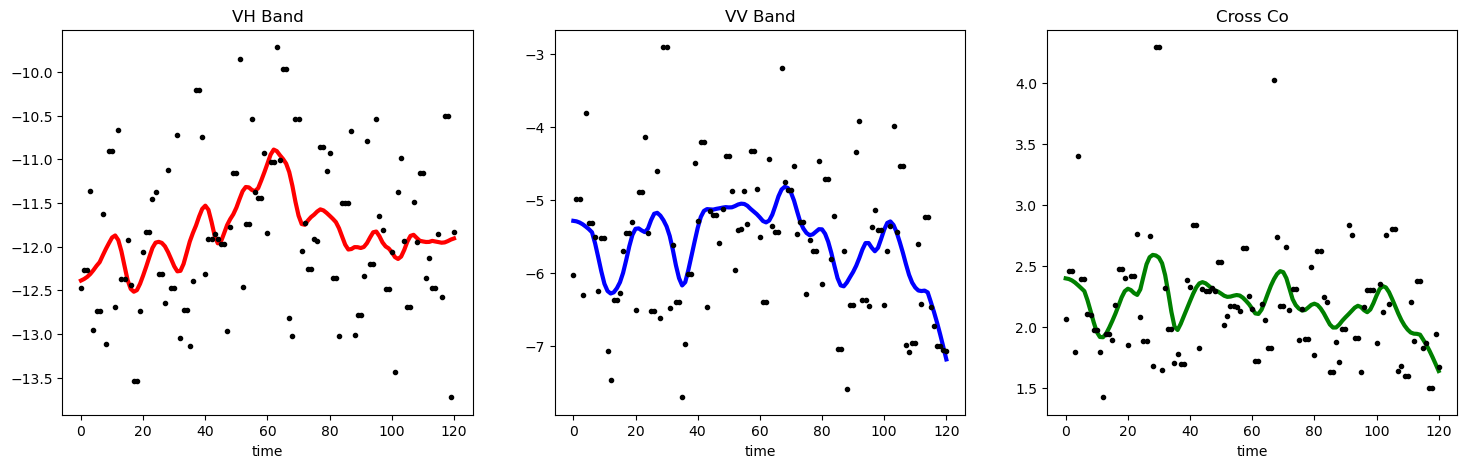

In [50]:
# plot the smoothed timeseries with intervals
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.plot(smoother.smooth_data[0], linewidth=3, color='red')
plt.plot(smoother.data[0], '.k')
plt.title(f"VH Band"); plt.xlabel('time')


#plot for vv band
plt.subplot(1,3,2)
plt.plot(smoother.smooth_data[1], linewidth=3, color='blue')
plt.plot(smoother.data[1], '.k')
plt.title(f"VV Band"); plt.xlabel('time')


#plot for cross copolarization
plt.subplot(1,3,3)
plt.plot(smoother.smooth_data[2], linewidth=3, color='green')
plt.plot(smoother.data[2], '.k')
plt.title(f"Cross Co"); plt.xlabel('time')



C-band:
Dual polarisation C-band is perhaps perfectly apt for irrigated rice monitoring, where the VV and
VH backscatter are dominated by specular double-bounce and volume scattering, respectively.
The shorter C-band signal displays stronger sensitivity than L-band also to the early growth stages
when the young rice plans are too small to be detected at L-band. This is illustrated in the bottom
figure above, where the wide range of different colours in the C-band RGB image represent
growth stage variations between the fields.

In [51]:
smooth_data = smooth_data.stack(variables=('bands', 'time'))

In [67]:
#split data into train and test
X_train, X_test, y_train, y_test = train_test_split(smooth_data.values, crop_presence_data['Class of Land'][0:599], test_size=0.2, random_state=42)

In [ ]:
#prepares catboost data

train_data = X_train

train_labels = y_train

#split data into train and test

test_data = catboost_pool = Pool(data=X_test, label=y_test)

model = CatBoostClassifier(iterations=1000,  
                           learning_rate=0.1, 
                           depth=6, 
                           loss_function='Logloss', 
                           eval_metric='F1', 
                           random_seed=42, 
                           has_time=True)

model.fit(train_data, train_labels, plot=True)

# make the prediction using the resulting model
preds_class = model.predict(test_data)
preds_proba = model.predict_proba(test_data)
print("class = ", preds_class)
print("proba = ", preds_proba)

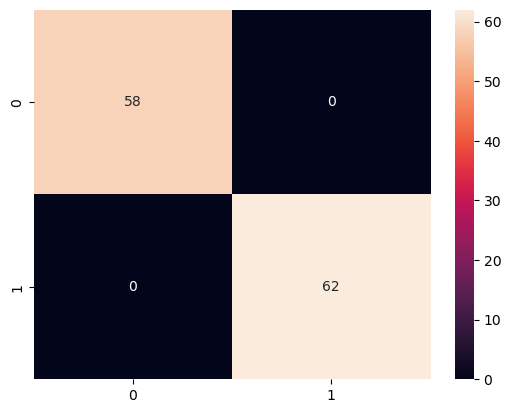

In [70]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, preds_class)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [60]:
#save model
model.save_model('PlanetaryComputerExamples/OpenDataChallenge/Data/Models/catboost_model.cbm')